# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Functions for my simulations
from dyn_cond_fig_functions import *


# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [41]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
    "axes.grid": True,
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Figure 6a

Text(200, 1.1, '$\\sim t^{-1/3}$')

Text(10, 0.3, '$\\sim t^{1/3}$')

Text(10000, 0.1, '$\\sim t^{1/3}$')

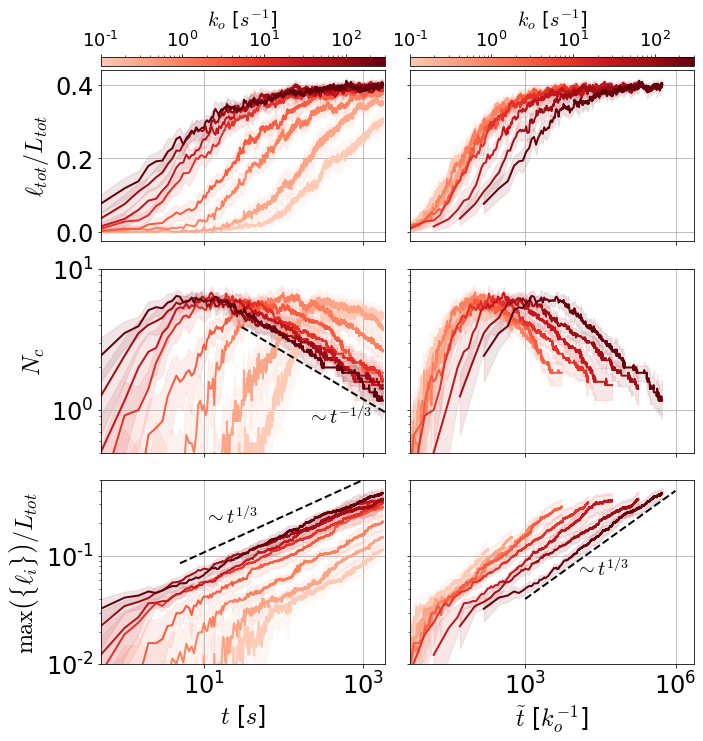

In [52]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin7.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin7.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin7.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin7.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin7.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin7.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin7.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin7.0um/",
                  }

cmap = plt.cm.Reds
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

fig, axarr = plt.subplots(3, 2, figsize=(10, 10), sharex='col', sharey='row')
with h5py.File('Figure7/fig7_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']

        # beads in condenates
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr[0,0], time_arr[1:min_length], mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)
        plot_confidence_int(axarr[0,1], time_arr[1:min_length]*kod, mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)

        # Number of condensates
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        plot_confidence_int(
            axarr[1,0], time_arr[1:min_length], mean[1:], std_dev[1:], num_runs, color=color, label=label
        )
        plot_confidence_int(
            axarr[1,1], time_arr[1:min_length]*kod, mean[1:], std_dev[1:], num_runs, color=color, label=label
        )


        # Beads in largest condensate
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        plot_confidence_int(
            axarr[2,0], time_arr[1:min_length], mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label
        )
        plot_confidence_int(
            axarr[2,1], time_arr[1:min_length]*kod, mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label
        )


    _ = axarr[0,0].set_ylabel("$\ell_{tot} / L_{tot}$")
    _ = axarr[0,0].set_xscale('log')
    _ = axarr[0,1].set_xscale('log')

    _ = axarr[1,0].set_ylabel("$N_c$")

    _ = axarr[2,0].set_ylabel(
        r"$\max \left(\{\ell_i\} \right)/L_{tot}$"
    )

    # _ = axarr[0,1].legend(loc='center right', bbox_to_anchor=(1, .4))
    # _ = axarr[0,1].legend(loc='upper left')

    _ = axarr[2,0].set_xlabel('$t$ [$s$]')
    _ = axarr[2,1].set_xlabel(r'$\tilde{t}$ [$k_o^{-1}$]')
    fig.tight_layout()

_ = axarr[0,0].set_xlim(0.5,1900)

_ = axarr[1,0].set_ylim(0.5, 10.)
_ = axarr[1,0].set_yscale('log')

_ = axarr[2,0].set_ylim(0.01, 0.5)
_ = axarr[2,0].set_yscale('log')

_ = axarr[1,0].plot(np.arange(30, 4000), 12*np.power(np.arange(30, 4000), -1./3.), 'k--', label=r'$1/N$')
_ = axarr[2,0].plot(np.arange(5, 4000), .05*np.power(np.arange(5, 4000), 1./3.), 'k--', label=r'$1/N$')
_ = axarr[2,1].plot(np.arange(1000, 1000000, 10000), .004*np.power(np.arange(1000, 1000000, 10000), 1./3.), 'k--', label=r'$1/N$')

_ = axarr[2,1].set_xlim(5)


norm = mcolors.LogNorm(vmin=.1, vmax=300)
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

cax0 = make_axes_locatable(axarr[0,0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04)

cax1 = make_axes_locatable(axarr[0,1]).append_axes("top", size="5%", pad=0.06)
cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04)

cbar.ax.tick_params(labelsize=18)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$k_o$ [$s^{-1}$]', fontsize=20)

cbar1.ax.tick_params(labelsize=18)
cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.set_label('$k_o$ [$s^{-1}$]', fontsize=20)

axarr[1,0].text(200, 1.1, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
axarr[2,0].text(10, .3, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')
axarr[2,1].text(10000, .1, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')

fig.savefig('Figure7/fig7_pin_ko.png', dpi=600, bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig4_cond_dyn_ko.png", dpi=300, bbox_inches="tight")

# Collect data

In [16]:
# slice_path = ceph_path / "DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations"

# cluster_similarity_threshold = .4 
# nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
# vmax = 40 # Max colorbar value in kymographs
# tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# # Consistent settings
# ss_ind = 1
# end_ind = None
# start_bead = 0
# end_bead = None
# part_min = 40

# pin_ko_data_dict = {}

# def parse_params(param_dir):
#     data_path = next(param_dir.glob("s*")) / "analysis/raw_data.h5"
#     with h5py.File(data_path, "r") as h5_data:
#         run_params = yaml.safe_load(h5_data.attrs["RunConfig"])
#         prot_params = yaml.safe_load(h5_data.attrs["ProteinConfig"])

#     return run_params["pinDist"], prot_params["proteins"][0]["ko_d"][1]


# for param_dir in slice_path.glob("*"):
#     print(param_dir)
#     try:
#         pin_dist, ko = parse_params(param_dir)
#         if pin_dist not in pin_ko_data_dict:
#             pin_ko_data_dict[pin_dist] = {}


#         sd_h5_file_lst = [h5p for h5p in param_dir.glob("s*/analysis/raw_data.h5")]

#         # For hdf5 file to help with graphing
#         with h5py.File(sd_h5_file_lst[0], "r") as h5d:
#             time_arr = h5d["time"][ss_ind:end_ind]
#             nbeads = h5d["raw_data"]["sylinders"][start_bead:end_bead, 0, 0].shape[0]

#         num_runs = len(sd_h5_file_lst)
#         min_run_length = min(
#             [len(h5py.File(h5p, "r")["time"]) for h5p in sd_h5_file_lst]
#         )

#         avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
#         avg_max_num_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
#         avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))

#         for ih, h5d in enumerate(sd_h5_file_lst):
#             h5_clust_file = h5d.parent / "cluster_analysis.h5"
#             with h5py.File(h5_clust_file, "r") as h5_data:
#                 cluster_grp = h5_data["clusters"]
#                 time_grp_list = sorted(
#                     cluster_grp.values(), key=lambda x: x.attrs["time"]
#                 )
#                 clusters = []
#                 for tg in time_grp_list:
#                     clusters += [[cla.Cluster(h5_data=c) for c in tg.values()]]


#             for c, clust_grp in enumerate(clusters):
#                 if c >= min_run_length:
#                     break
#                 # Secondary thresholding
#                 clust_grp = [
#                     clust for clust in clust_grp if len(clust.part_ids) > part_min
#                 ]

#                 num_beads = 0
#                 max_beads = 0
#                 for i, clust in enumerate(clust_grp):
#                     num_beads += len(clust.part_ids)
#                     max_beads = max(max_beads, len(clust.part_ids))

#                 avg_num_clust_arr[ih, c] = len(clust_grp)
#                 avg_num_clust_beads_arr[ih, c] += num_beads
#                 avg_max_num_beads_arr[ih, c] = max_beads

#         num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
#         num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
#         num_clust_mean = avg_num_clust_arr.mean(axis=0)
#         num_clust_std_dev = avg_num_clust_arr.std(axis=0)
#         max_num_bead_mean = avg_max_num_beads_arr.mean(axis=0)
#         max_num_bead_std_dev = avg_max_num_beads_arr.std(axis=0)
#         pin_ko_data_dict[pin_dist][ko] = [
#             num_bead_mean,
#             num_bead_std_dev,
#             num_clust_mean,
#             num_clust_std_dev,
#             max_num_bead_mean,
#             max_num_bead_std_dev,
#             num_runs,
#         ]

#     except:
#         raise
#         print("Error occured")

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod30_Pin5.0um


Note: This takes about 45 minutes to collect all the data.

In [11]:
# # Store pin_ke_data_dict as an hdf5 file
# with h5py.File('Figure7/fig7_pin_ko_data_dict.h5', 'w') as h5d:
#     _ = h5d.create_dataset('time', data=time_arr)
#     for pin_dist, ko_data in pin_ko_data_dict.items():
#         for ko, data in ko_data.items():
#             dset = h5d.create_dataset(f'kod{ko:.3g}_Pin{pin_dist:.1f}um', data=np.vstack(data[:-1]).T)
#             dset.attrs['pin_dist'] = pin_dist
#             dset.attrs['ko'] = ko
#             dset.attrs['num_runs'] = data[-1]